In [3]:
from scipy.stats import pearsonr, spearmanr
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy
import pingouin as pg
from statsmodels.formula.api import ols
import seaborn as sns


In [27]:
plt.style.use('ggplot')
pd.set_option('mode.use_inf_as_na', True)

def Correlation(df, corFunc, isSimmetric=True):
    names = df.columns
    length = len(names)
    correlation = np.zeros((length, length))
    valuesP = np.zeros((length, length))
    
    if isSimmetric:
        for i in range(length):
            for j in range(i, length):
                res = corFunc(df[names[i]], df[names[j]])
                correlation[i, j] = correlation[j, i] = res[0]
                valuesP[i, j] = valuesP[j, i] = res[1]
    else:
        for i in range(length):
            for j in range(length):
                res = corFunc(df[names[i]], df[names[j]])
                correlation[i, j] = res[0]
                valuesP[i, j] = res[1]
    
    dfValP = pd.DataFrame(valuesP)
    dfCorrelation = pd.DataFrame(correlation)
    dfCorrelation.columns = dfValP.columns = names
    dfCorrelation.index = dfValP.index = names
    
    return dfCorrelation, dfValP

def partialCorrelation(df):
    names = df.columns
    length = len(names)
    correlation = np.zeros((length, length))
    correlation[range(length), range(length)] = 1
    valuesP = np.zeros((length, length))
    valuesP[range(length), range(length)] = 0

    for i in range(length):
        for j in range(i + 1, length):
            covNames = list(df.columns)
            covNames.remove(names[i])
            if names[j] in covNames:
                covNames.remove(names[j])
            res = pg.partial_corr(data=df, x=names[i], y=names[j], covar=covNames)
            correlation[i, j] = correlation[j, i] = res['r'].values
            valuesP[i, j] = valuesP[j, i] = res['p-val'].values
    
    dfValP = pd.DataFrame(valuesP)
    dfCorrelation = pd.DataFrame(correlation)
    dfCorrelation.columns = dfValP.columns = names
    dfCorrelation.index = dfValP.index = names
    
    return dfCorrelation, dfValP

def multipleCorrelation(df):
    names = df.columns
    length = len(names)
    correlation = np.zeros((length))
    valuesP = np.zeros((length))
    
    for i, name in enumerate(names):
        formula = str(name) + ' ~ ' + ' + '.join([n for j, n in enumerate(names) if j != i])
        mod = ols(formula=formula, data=df)
        res = mod.fit()
        correlation[i] = res.rsquared ** 0.5
        valuesP[i] = res.f_pvalue
    
    return correlation, valuesP

def correlationRelation(var1, var2, n_bins=5):

    length = len(var1)
    group_int_number = lambda n: round (3.31*np.log10(n)+1) if round (3.31*np.log10(n)+1) >=2 else 2

    n_bins = group_int_number(length)
    bins = np.linspace(var1.min(), var1.max(), n_bins)
    args = np.digitize(var1, bins)

    groups = [list() for _ in range(n_bins)]

    for idx, bin_num in enumerate(args):
        groups[bin_num - 1].append(var2[idx])

    groups = [np.array(group) for group in groups if group]
    groups

    gen_mean = var2.mean()
    gen_var = var2.var()
    factor_var = sum((group.mean() - gen_mean)**2 * len(group) for group in groups) / length
    etto = (factor_var / gen_var) ** 0.5
    statistic = (length - n_bins)/(n_bins - 1) * etto ** 2 / (1 - etto ** 2)
    valueP = 1 - scipy.stats.f.cdf(statistic, (n_bins - 1), (length - n_bins), loc=0, scale=1)
    return etto, valueP

names = [i + 1 for i in range(5)]

df_base = pd.read_excel('ms-data2-2022.xlsx', sheet_name='2-1', header=None, names=names)


In [9]:
df_base.head()

,1,2,3,4,5
0,13.576533,8.444634,42.737,7.574,2.369
1,9.988142,13.552947,23.261,1.660,6.072
2,8.190783,14.466266,13.439,-5.422,3.504
3,8.412009,10.531638,15.174,-5.483,4.532
4,10.021344,8.826599,24.573,3.247,7.447


c:\Users\lesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


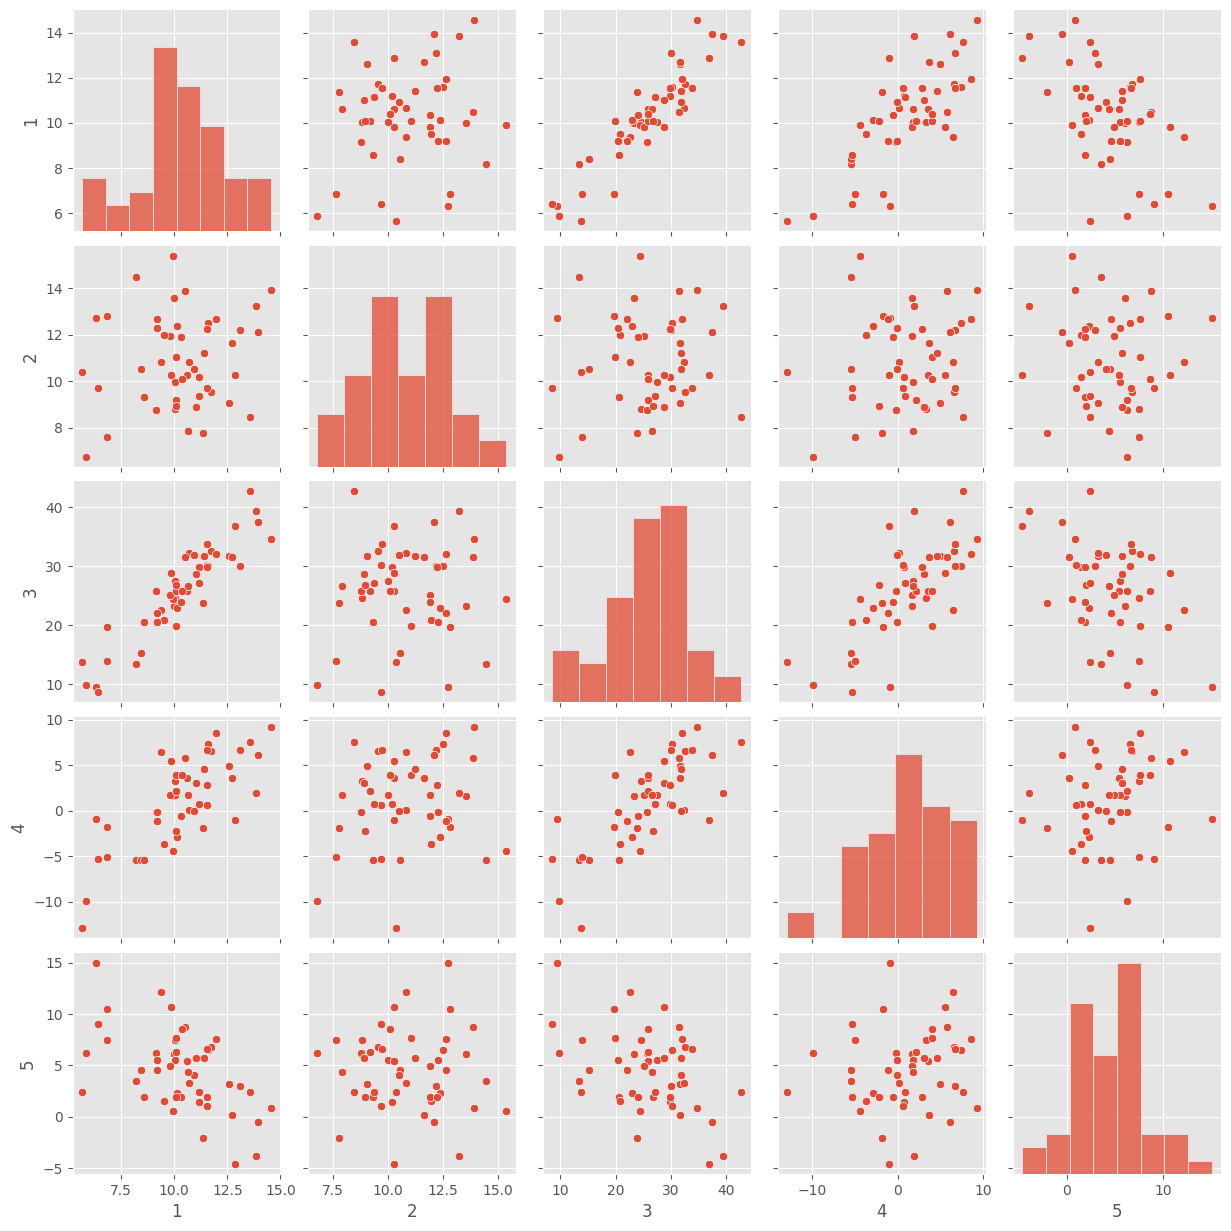

In [10]:
sns.pairplot(df_base)


<Axes: >

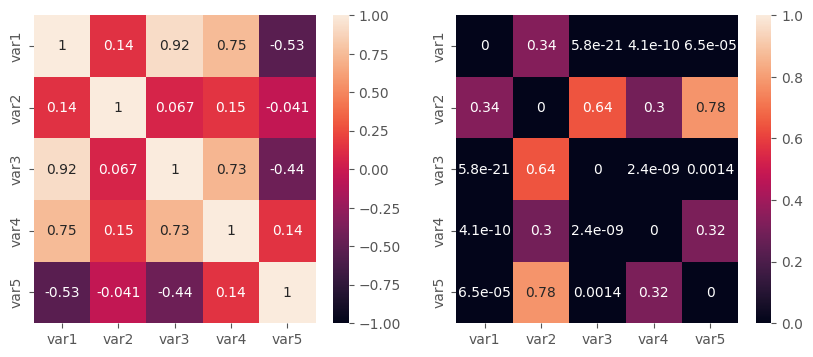

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

corr, p_vals = Correlation(df_base, pearsonr)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=ax1)
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1, ax=ax2)

<Axes: >

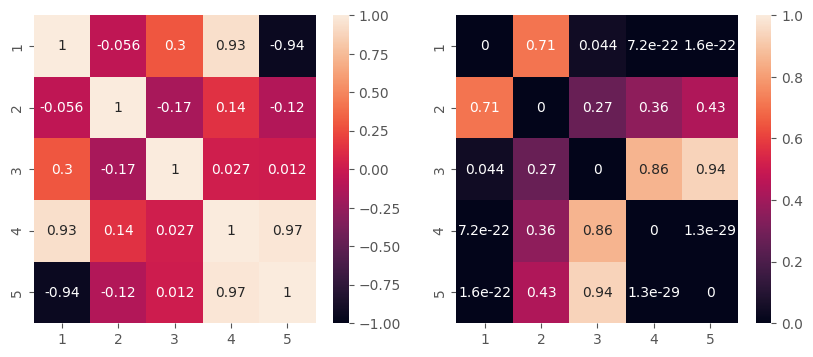

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

corr, p_vals = partialCorrelation(df_base)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=ax1)
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1, ax=ax2)

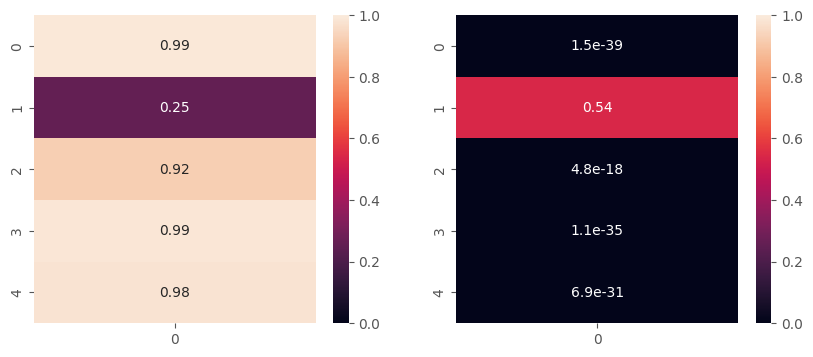

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
corr, p_vals = multipleCorrelation(df_base)
sns.heatmap(corr[..., None], annot=True, vmin=0, vmax=1, ax=ax1);
sns.heatmap(p_vals[..., None], annot=True, vmin=0, vmax=1, ax=ax2);

<Axes: >

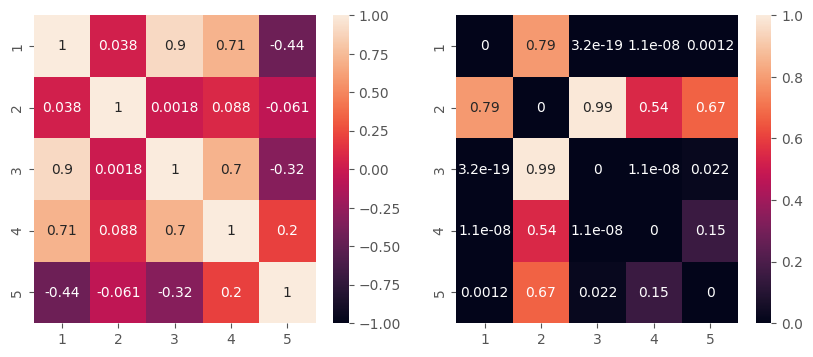

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

corr, p_vals = Correlation(df_base, spearmanr)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=ax1)
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1, ax=ax2)

<Axes: >

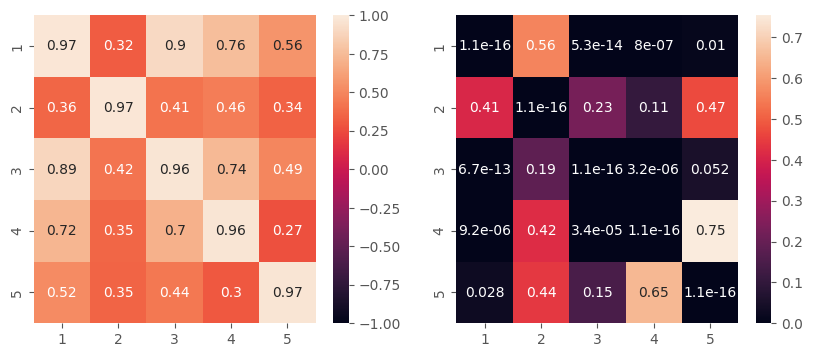

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

corr, p_vals = Correlation(df_base, correlationRelation, isSimmetric=False)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=ax1)
sns.heatmap(p_vals, annot=True, ax=ax2)

<Axes: title={'center': 'Correlation relaiton'}>

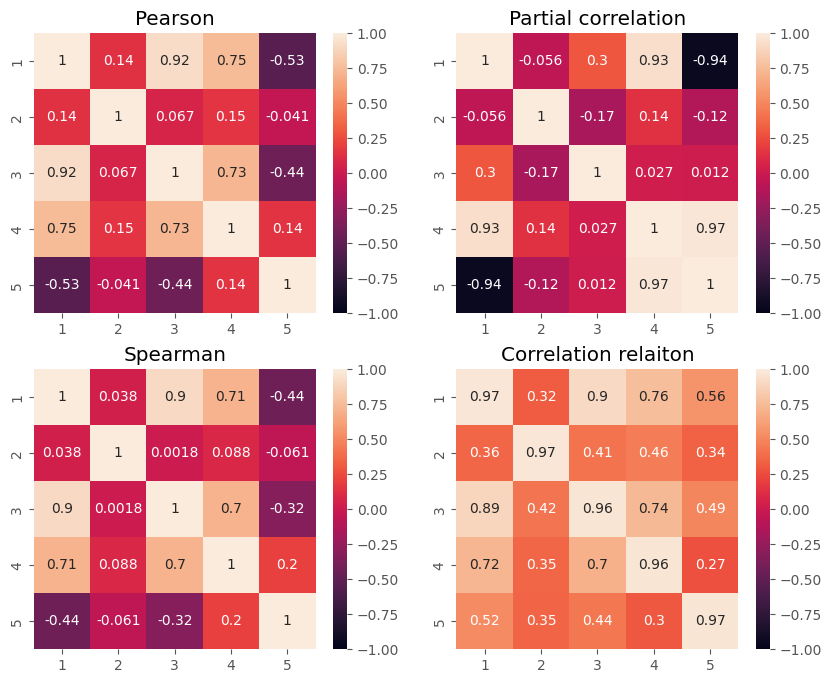

In [37]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
ax1.set_title('Pearson')
ax2.set_title('Partial correlation')
ax3.set_title('Spearman')
ax4.set_title('Correlation relaiton')

corr, p_vals = Correlation(df_base, pearsonr)
sns.heatmap(Correlation(df_base, pearsonr)[0], annot=True, vmin=-1, vmax=1, ax=ax1)
sns.heatmap(partial_correlation(df_base)[0], annot=True, vmin=-1, vmax=1, ax=ax2)
sns.heatmap(Correlation(df_base, spearmanr)[0], annot=True, vmin=-1, vmax=1, ax=ax3)
sns.heatmap(Correlation(df_base, correlation_relation, isSimmetric=False)[0], annot=True, vmin=-1, vmax=1, ax=ax4)